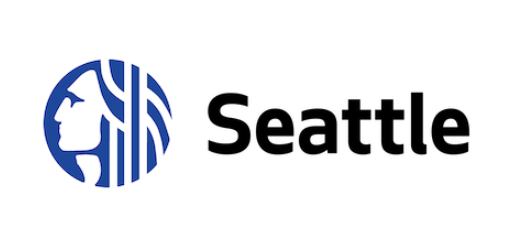

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', 80)

# Contexte
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.



# Objectifs
Vous cherchez également à évaluer l’intérêt de l’**ENERGY STAR Score** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

In [2]:
df = pd.read_csv('Building_Benchmarking.csv') 

In [3]:
df_log = pd.read_csv('Building_Log_Benchmarking.csv') 

Head() pour afficher les 5 premières lignes du dataframe `df`.

In [4]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,47.612190,-122.337997,1927,1.0,12.0,88434,0.0,88434.0,Hotel,Hotel,NaN,NaN,65.0,78.9,173.5,6981428.0,2023032.0,3686160.0,1272388.0,249.43,100.00,0.00,0.00
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,47.613106,-122.333358,1996,1.0,11.0,103566,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,51.0,94.4,191.3,8354235.0,0.0,3905411.0,4448985.0,263.51,80.99,14.55,4.46
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,47.613349,-122.337699,1969,1.0,41.0,961990,0.0,961990.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,18.0,96.6,242.7,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,78.72,10.40,0.00
3,5,2015,NonResidential,Hotel,HOTEL MAX,47.614216,-122.336609,1926,1.0,10.0,61320,0.0,61320.0,Hotel,Hotel,NaN,NaN,1.0,460.4,636.3,28229320.0,23458518.0,2769023.0,2001894.0,1936.34,100.00,0.00,0.00
4,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),47.616439,-122.336764,1999,1.0,2.0,97288,37198.0,60090.0,Police Station,Police Station,NaN,NaN,NaN,135.7,313.5,12051984.0,0.0,7271004.0,4781283.0,304.62,91.31,0.00,0.00


la taille du dataframe avec shape

In [5]:
df.shape

(2674, 28)

min, max, moyenne, écart type, etc) pour toutes les variables quantitatives avec describes

In [6]:
df.describe()

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2.674000e+03,2674.000000,2.674000e+03,1786.000000,2674.000000,2674.000000,2.674000e+03,2.674000e+03,2.674000e+03,2.674000e+03,2674.000000,2674.000000,2674.000000,2674.000000
mean,15453.525804,2015.512341,47.614603,-122.333696,1960.838818,1.114435,4.254675,1.184212e+05,14939.116679,1.034821e+05,64.709966,71.807530,178.210135,7.785679e+06,4.035296e+05,5.683280e+06,1.658018e+06,158.824570,82.248280,13.386945,2.135636
std,13154.516387,0.499941,0.046718,0.024022,32.955544,2.375913,6.492263,2.682347e+05,46765.031227,2.497738e+05,28.472265,74.093515,188.132233,2.454841e+07,4.330989e+06,1.816080e+07,5.853002e+06,549.857837,20.126535,21.167726,6.351193
min,1.000000,2015.000000,47.499170,-122.411820,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,1.000000,0.200000,0.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.080000,18.350000,0.000000,0.000000
25%,572.000000,2015.000000,47.585030,-122.343201,1929.000000,1.000000,1.000000,2.901975e+04,0.000000,2.812600e+04,48.000000,33.100000,77.400000,1.180530e+06,0.000000e+00,7.005642e+05,0.000000e+00,19.202500,66.235000,0.000000,0.000000
50%,20986.000000,2016.000000,47.611655,-122.333354,1965.000000,1.000000,2.000000,4.881950e+04,0.000000,4.664500e+04,72.000000,51.750000,132.600002,2.456574e+06,0.000000e+00,1.596202e+06,4.220580e+05,47.150000,90.860000,1.950000,0.000000
75%,24374.000000,2016.000000,47.645885,-122.322899,1988.000000,1.000000,4.000000,1.068600e+05,0.000000,9.530650e+04,88.000000,81.400001,205.200001,6.785792e+06,0.000000e+00,4.855296e+06,1.329851e+06,133.670000,100.000000,24.932500,0.000000
max,50226.000000,2016.000000,47.733870,-122.258640,2015.000000,111.000000,76.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,1.381912e+08,12307.160000,100.000000,630.150000,150.940000


In [7]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'pourcentage_LargestPropertyUseTypeGFA',
       'pourcentage_SecondLargestPropertyUseTypeGFA',
       'pourcentage_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [8]:
for col in df.columns:
    print(f'{col :-<70} {df[col].nunique()}')

OSEBuildingID--------------------------------------------------------- 1409
DataYear-------------------------------------------------------------- 2
BuildingType---------------------------------------------------------- 4
PrimaryPropertyType--------------------------------------------------- 25
PropertyName---------------------------------------------------------- 2578
Latitude-------------------------------------------------------------- 2510
Longitude------------------------------------------------------------- 2430
YearBuilt------------------------------------------------------------- 113
NumberofBuildings----------------------------------------------------- 14
NumberofFloors-------------------------------------------------------- 43
PropertyGFATotal------------------------------------------------------ 1385
PropertyGFAParking---------------------------------------------------- 319
PropertyGFABuilding(s)------------------------------------------------ 1398
ListOfAllPropertyUseTypes-

In [9]:
#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OSEBuildingID                                2674 non-null   int64  
 1   DataYear                                     2674 non-null   int64  
 2   BuildingType                                 2674 non-null   object 
 3   PrimaryPropertyType                          2674 non-null   object 
 4   PropertyName                                 2674 non-null   object 
 5   Latitude                                     2674 non-null   float64
 6   Longitude                                    2674 non-null   float64
 7   YearBuilt                                    2674 non-null   int64  
 8   NumberofBuildings                            2674 non-null   float64
 9   NumberofFloors                               2674 non-null   float64
 10  

# Feature Engineering

## Build Age

In [10]:
df['Build_Age'] = df['DataYear'] - df['YearBuilt']

In [11]:
df['Build_Age'].max()

116

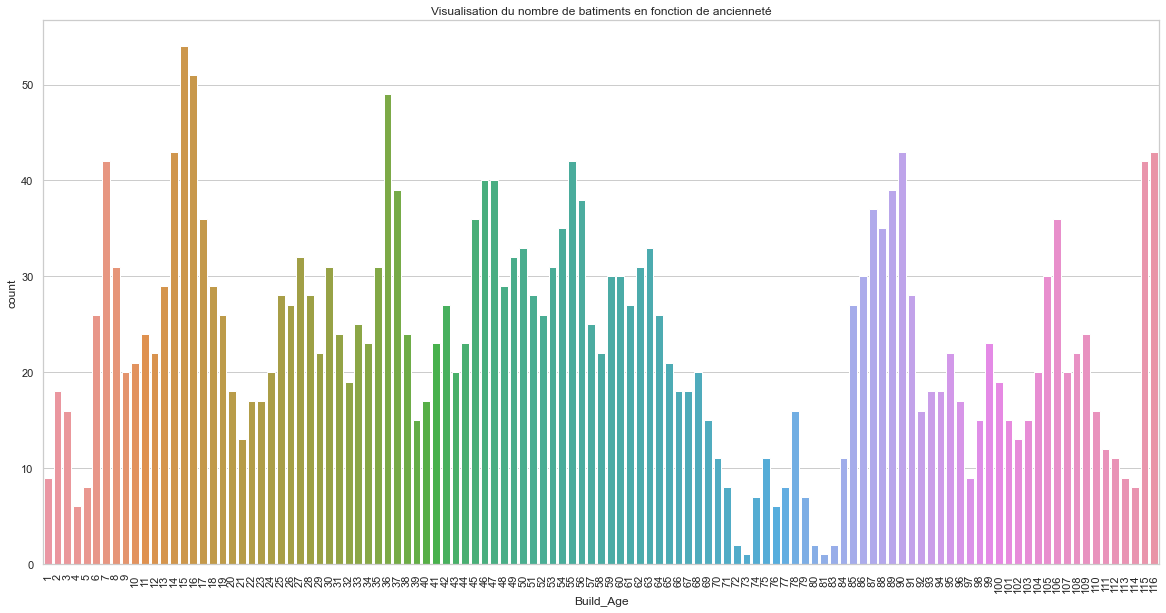

In [12]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.set_style('whitegrid')
sns.countplot(x='Build_Age', data=df).set(title='Visualisation du nombre de batiments en fonction de ancienneté')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [13]:
df.drop(['OSEBuildingID', 'DataYear','YearBuilt'], axis=1, inplace=True)

## Surface Nb de Building

In [14]:
df = df.assign(surface_nb_building=lambda x: round( x['PropertyGFATotal'] / x['NumberofBuildings'], 2))

In [15]:
df.drop(['NumberofBuildings'], axis=1, inplace=True)

## Nombre d'activités

In [16]:
# Splittez la colonne en utilisant la méthode str.split()
df['ListOfAllPropertyUseTypes_split'] = df['ListOfAllPropertyUseTypes'].str.split(',')

In [17]:
# Compter le nombre d'éléments dans chaque ligne en utilisant apply()
df['nombre_activités'] = df['ListOfAllPropertyUseTypes_split'].apply(lambda x: len(x))

In [18]:
df.drop(['ListOfAllPropertyUseTypes_split'], axis=1, inplace=True)

## Energy
Nous calculons le poucentage de chaque energy ('SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu) en fonction de l'énergy total use

In [19]:
df = df.assign(pourcentage_Electricity=lambda x: round( x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [20]:
df = df.assign(pourcentage_NaturalGas=lambda x: round( x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [21]:
df = df.assign(pourcentage_SteamUse=lambda x: round( x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [22]:
df[[ 'pourcentage_Electricity', 'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse
0,52.80,18.23,28.98
1,46.75,53.25,0.00
2,68.05,5.07,26.88
3,9.81,7.09,83.10
4,60.33,39.67,0.00
...,...,...,...
2669,61.70,38.30,0.00
2670,41.73,58.27,0.00
2671,31.08,68.92,0.00
2672,48.49,51.51,0.00


In [23]:
df.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'], axis=1, inplace=True)

## Localisation batiment - Geopandas

In [24]:
import geopandas as gpd
from shapely.geometry import Point

In [25]:
# Create a geometry column by constructing Point objects from the lon and lat columns
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [26]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [27]:
gdf.crs

In [28]:
gdf = gdf[gdf.is_valid == True]

<AxesSubplot:>

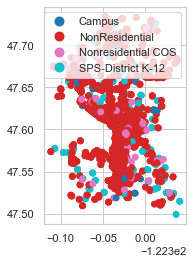

In [29]:
gdf['geometry'].centroid
gdf.plot(column = "BuildingType",legend=True)

Suite à notre feature engineering, nous vous rajouter ces nouvelles features à notre dataset df_log

In [30]:
df_feature_engineering = df[['Build_Age',
         'surface_nb_building', 'nombre_activités', 'pourcentage_Electricity',
        'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

In [31]:
to_log = ['Build_Age',
          'surface_nb_building', 'nombre_activités', 'pourcentage_Electricity',
          'pourcentage_NaturalGas', 'pourcentage_SteamUse']

In [32]:
# apply log(x+1) element-wise to a subset of columns
df_log_2 = df_feature_engineering [to_log].applymap(lambda x: np.log(x+1))

# rename columns
df_log_2.columns = 'log_' + df_log_2.columns

In [33]:
# concat les deux variables à prédire et PrimaryPropertyType
df_log_3 = pd.concat([df_log, df_log_2],  axis=1)

In [34]:
df_log_3

,log_YearBuilt,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),log_SiteEnergyUse(kBtu),log_SteamUse(kBtu),log_Electricity(kBtu),log_NaturalGas(kBtu),log_TotalGHGEmissions,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse
0,7.564238,0.693147,2.564949,11.390023,0.000000,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,15.758764,14.520108,15.120096,14.056407,5.523179,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530
1,7.599401,0.693147,2.484907,11.547974,9.620129,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,15.938279,0.000000,15.177874,15.308187,5.577879,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000
2,7.585789,0.693147,3.737670,13.776760,0.000000,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,18.107758,16.794117,17.722771,15.126516,7.631664,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910
3,7.563720,0.693147,2.397895,11.023878,0.000000,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,17.155872,16.970744,14.834005,14.509605,7.569071,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007
4,7.600902,0.693147,1.098612,11.485441,10.524037,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,16.304740,0.000000,15.799405,15.380220,5.722343,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,7.596392,0.693147,0.693147,9.416948,0.000000,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,13.652694,0.000000,13.169766,12.693044,3.088311,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000
2670,7.603399,0.693147,0.693147,9.680406,0.000000,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,13.764509,0.000000,12.890550,13.224434,3.501646,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000
2671,7.588324,0.693147,0.693147,9.484785,0.000000,9.484785,4.071247,3.769768,0.000000,6.084955,6.614457,15.567472,0.000000,14.398932,15.195218,5.414054,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000
2672,7.595890,0.693147,0.693147,9.554072,0.000000,9.554072,3.867235,3.852273,1.488400,3.951244,4.666265,13.486273,0.000000,12.762458,12.822884,3.140265,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000


Nous supprimons maintenant les features qui nous semblent moins pertinentes pour la suite de notre analyse

In [35]:
df_log_3.columns

Index(['log_YearBuilt', 'log_NumberofBuildings', 'log_NumberofFloors',
       'log_PropertyGFATotal', 'log_PropertyGFAParking',
       'log_PropertyGFABuilding(s)',
       'log_pourcentage_LargestPropertyUseTypeGFA',
       'log_pourcentage_SecondLargestPropertyUseTypeGFA',
       'log_pourcentage_ThirdLargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
       'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)',
       'log_TotalGHGEmissions', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'log_Build_Age', 'log_surface_nb_building', 'log_nombre_activités',
       'log_pourcentage_Electricity', 'log_pourcentage_NaturalGas',
       'log_pourcentage_SteamUse'],
      dtype='object')

In [36]:
df_log_3.drop(['log_YearBuilt','log_PropertyGFAParking','log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
         'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)','log_TotalGHGEmissions'], axis=1, inplace=True)

# Encodage

In [37]:
cat_cols = ['LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
num_cols = ['log_YearBuilt', 'log_NumberofBuildings', 'log_NumberofFloors',
       'log_PropertyGFATotal', 'log_PropertyGFAParking',
       'log_PropertyGFABuilding(s)', 'log_LargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
       'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)',
       'log_TotalGHGEmissions']

In [38]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse
0,0.693147,2.564949,11.390023,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530
1,0.693147,2.484907,11.547974,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000
2,0.693147,3.737670,13.776760,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910
3,0.693147,2.397895,11.023878,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007
4,0.693147,1.098612,11.485441,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000
2670,0.693147,0.693147,9.680406,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000
2671,0.693147,0.693147,9.484785,9.484785,4.071247,3.769768,0.000000,6.084955,6.614457,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000
2672,0.693147,0.693147,9.554072,9.554072,3.867235,3.852273,1.488400,3.951244,4.666265,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000


In [39]:
df_log_3.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(30)


occurring_cat = [cat for cat in df_log_3.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(40).index]


for cat in occurring_cat:
    df_log_3[cat] = np.where((df_log_3['LargestPropertyUseType'] == cat)|
                           (df_log_3['SecondLargestPropertyUseType'] == cat)|
                           (df_log_3['ThirdLargestPropertyUseType'] == cat), 1, 0) 

In [40]:
df_log_3.columns

Index(['log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal',
       'log_PropertyGFABuilding(s)',
       'log_pourcentage_LargestPropertyUseTypeGFA',
       'log_pourcentage_SecondLargestPropertyUseTypeGFA',
       'log_pourcentage_ThirdLargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'log_Build_Age',
       'log_surface_nb_building', 'log_nombre_activités',
       'log_pourcentage_Electricity', 'log_pourcentage_NaturalGas',
       'log_pourcentage_SteamUse', 'Small- and Mid-Sized Office', 'Warehouse',
       'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
       'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
       'Self-Storage Facility', 'Other - Recreation', 'Parking',
       'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
       'Refrigerated Warehouse', 'Social

## GFA Property encode
### Assign log_pourcentage_LargestPropertyUseTypeGFA

In [41]:
# colonne pour la surface GFA log_pourcentage_LargestPropertyUseTypeGFA
gfa_col = 'log_pourcentage_LargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'LargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

### Assign log_pourcentage_SecondLargestPropertyUseTypeGFA

In [42]:
# colonne pour la surface GFA log_pourcentage_SecondLargestPropertyUseTypeGFA
gfa_col = 'log_pourcentage_SecondLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'SecondLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

### Assign log_pourcentage_ThirdLargestPropertyUseTypeGFA

In [43]:
# colonne pour la surface GFA log_pourcentage_ThirdLargestPropertyUseTypeGFA
gfa_col ='log_pourcentage_ThirdLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col ='ThirdLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

In [44]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Urgent Care/Clinic/Other Outpatient,Library,Bank Branch,Other - Services,Hospital (General Medical & Surgical),Other - Education,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other/Specialty Hospital,Strip Mall,Data Center,Performing Arts,Adult Education,Other - Restaurant/Bar,Pre-school/Daycare,Prison/Incarceration
0,0.693147,2.564949,11.390023,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.693147,2.484907,11.547974,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000,0.000000,0.0,0.0,0.0,0.0,4.406597,0.0,0.0,0.0,0.0,0.0,0.000000,2.744061,0.0,0.0,1.697449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.693147,3.737670,13.776760,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910,0.000000,0.0,0.0,0.0,0.0,4.378520,0.0,0.0,0.0,0.0,0.0,0.000000,2.433613,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,0.693147,2.397895,11.023878,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.693147,1.098612,11.485441,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000,4.615121,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2670,0.693147,0.693147,9.680406,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.615121,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2671,0.6

In [45]:
# drop catégorical feature
df_log_3.drop(['LargestPropertyUseType',
               'SecondLargestPropertyUseType', 
               'ThirdLargestPropertyUseType', 
               'log_pourcentage_LargestPropertyUseTypeGFA',
               'log_pourcentage_SecondLargestPropertyUseTypeGFA',
               'log_pourcentage_ThirdLargestPropertyUseTypeGFA'], axis=1, inplace=True)

In [46]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Urgent Care/Clinic/Other Outpatient,Library,Bank Branch,Other - Services,Hospital (General Medical & Surgical),Other - Education,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other/Specialty Hospital,Strip Mall,Data Center,Performing Arts,Adult Education,Other - Restaurant/Bar,Pre-school/Daycare,Prison/Incarceration
0,0.693147,2.564949,11.390023,11.390023,4.380776,5.161925,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.693147,2.484907,11.547974,11.390792,4.558079,5.259057,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000,0.000000,0.0,0.0,0.0,0.0,4.406597,0.0,0.0,0.0,0.0,0.0,0.000000,2.744061,0.0,0.0,1.697449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.693147,3.737670,13.776760,13.776760,4.580877,5.495938,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910,0.000000,0.0,0.0,0.0,0.0,4.378520,0.0,0.0,0.0,0.0,0.0,0.000000,2.433613,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,0.693147,2.397895,11.023878,11.023878,6.134265,6.457241,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.693147,1.098612,11.485441,11.003615,4.917789,5.750984,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.249923,5.091908,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000,4.615121,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2670,0.693147,0.693147,9.680406,9.680406,4.100989,4.746670,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.615121,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2671,0.693147,0.693147,9.484785,9.484785,6.084955,6.614457,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.071247,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.769768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2672,0.693147,0.693147,9.554072,9.554072,3.951244,4.666265,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.867235,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.852273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4

# Target Feature

In [47]:
# on rajoute les valeurs à prédire et l'énergystarsscore pour pouvoir évaluer la perfomance de notre model
df_energy = df[['SiteEnergyUse(kBtu)', 'ENERGYSTARScore']]

In [48]:
df_emissions = df[['TotalGHGEmissions', 'ENERGYSTARScore']]

In [49]:
# concat les deux variables à prédire
df_energy = pd.concat([df_log_3, df_energy],  axis=1)
df_emissions = pd.concat([df_log_3, df_emissions],  axis=1)

In [50]:
df_energy.to_csv('Building_Energy_Benchmarking.csv', index=False, header=True)
df_emissions.to_csv('Building_Emissions_Benchmarking.csv', index=False, header=True)

In [51]:
df_pred_energy = pd.read_csv('Building_Energy_Benchmarking.csv') 

In [52]:
df_pred_energy.isna().sum()

log_NumberofBuildings                                0
log_NumberofFloors                                   0
log_PropertyGFATotal                                 0
log_PropertyGFABuilding(s)                           0
log_SiteEUI(kBtu/sf)                                 0
log_SourceEUI(kBtu/sf)                               0
log_Build_Age                                        0
log_surface_nb_building                              0
log_nombre_activités                                 0
log_pourcentage_Electricity                          0
log_pourcentage_NaturalGas                           0
log_pourcentage_SteamUse                             0
Small- and Mid-Sized Office                          0
Warehouse                                            0
K-12 School                                          0
Other                                                0
Retail Store                                         0
Hotel                                                0
Worship Fa

# Prediction Energy sans ENERGYSTARScore

In [53]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from math import sqrt

In [54]:
# Sélection des variables X et y
X=df_pred_energy.drop(['SiteEnergyUse(kBtu)','ENERGYSTARScore'],axis=1)
y= df_pred_energy['SiteEnergyUse(kBtu)']

In [55]:
# Séparation des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## DummyRegressor

### strategy='mean'

In [56]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -0.0002725392536764293


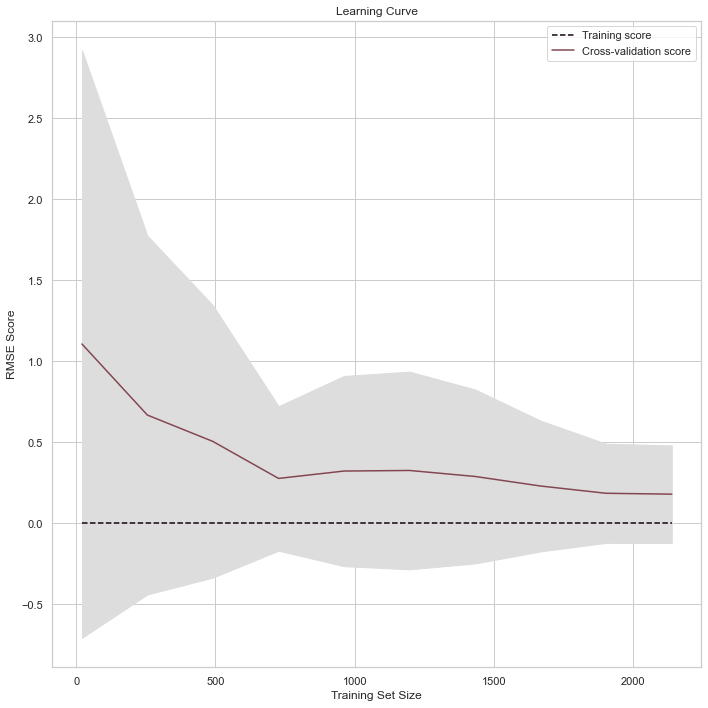

In [57]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)


# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = -2.7963550629728218e-05


(16808.90039, 873923712.0)

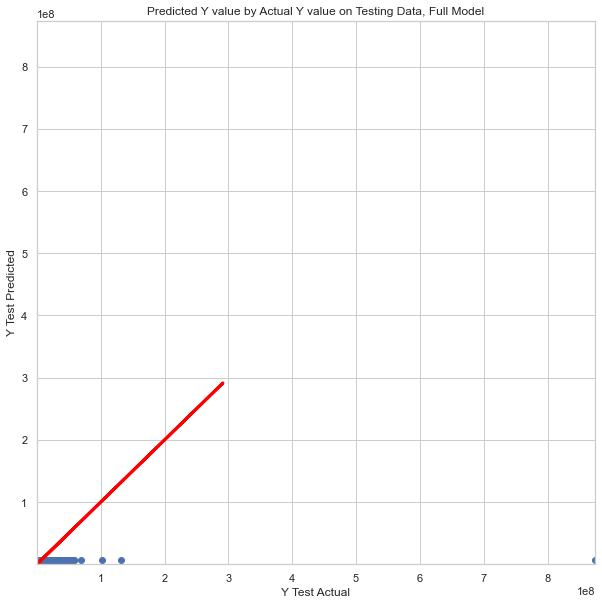

In [58]:
print('Coeff R2 =', dummy_regr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

### strategy='median'

In [59]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -0.022145687592258323


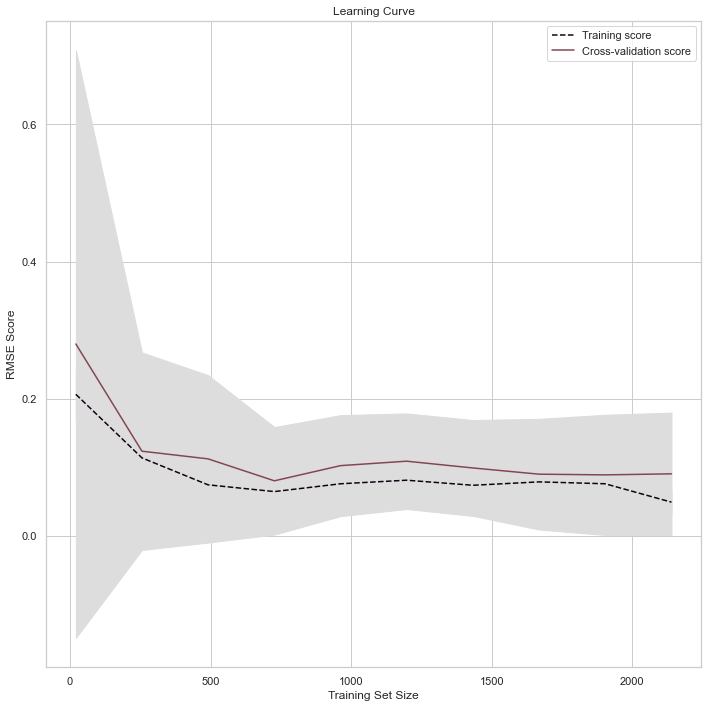

In [60]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = -0.04713595344032573


(16808.90039, 873923712.0)

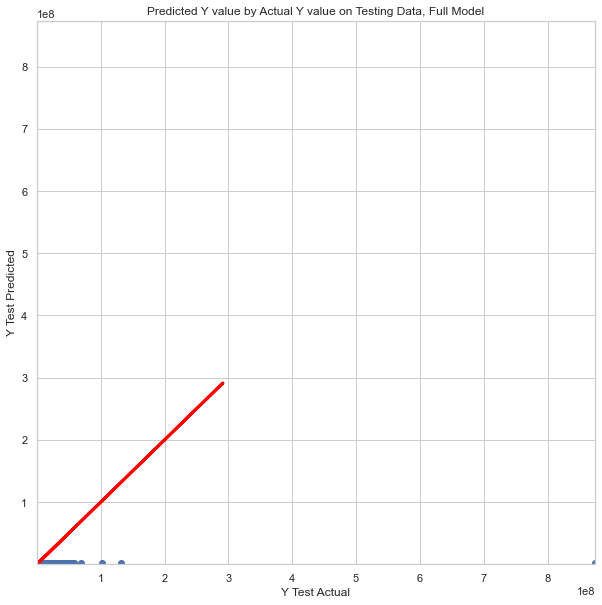

In [61]:
print('Coeff R2 =', dummy_regr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

## Regression Linéaire

In [62]:
# Initialisation et entraînement du modèle
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = lr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  0.1998027878894313


In [63]:
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [64]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [65]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

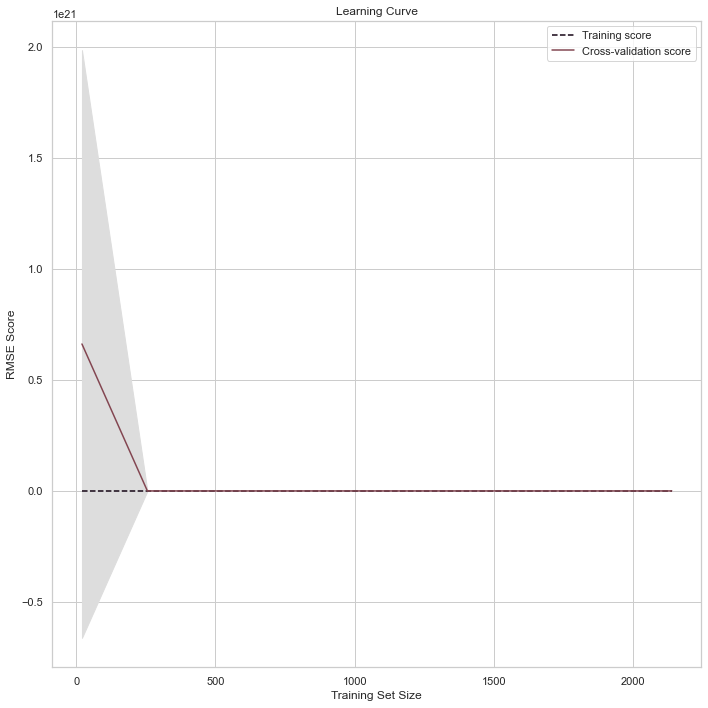

In [66]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.4221418523337923


(16808.90039, 873923712.0)

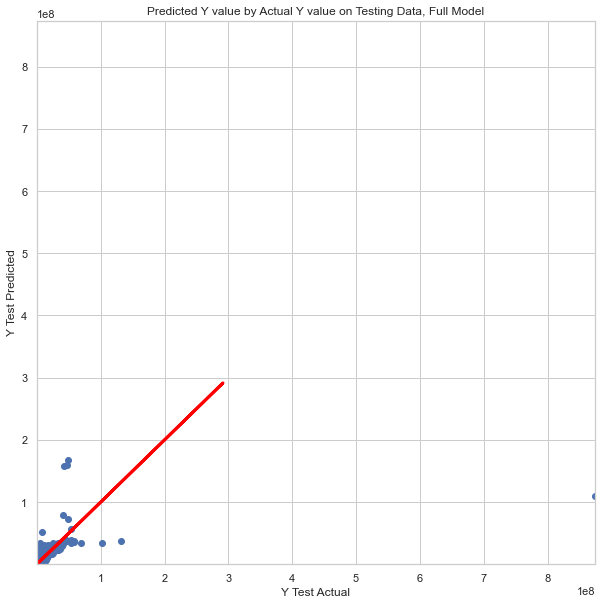

In [67]:
print('Coeff R2 =', lr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, lr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

## Lasso

In [68]:
las = Lasso(alpha=0.001)
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = las.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560941781509211
0.20600219928005603


In [69]:
train_sizes, train_scores, test_scores = learning_curve(Lasso(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [70]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [71]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

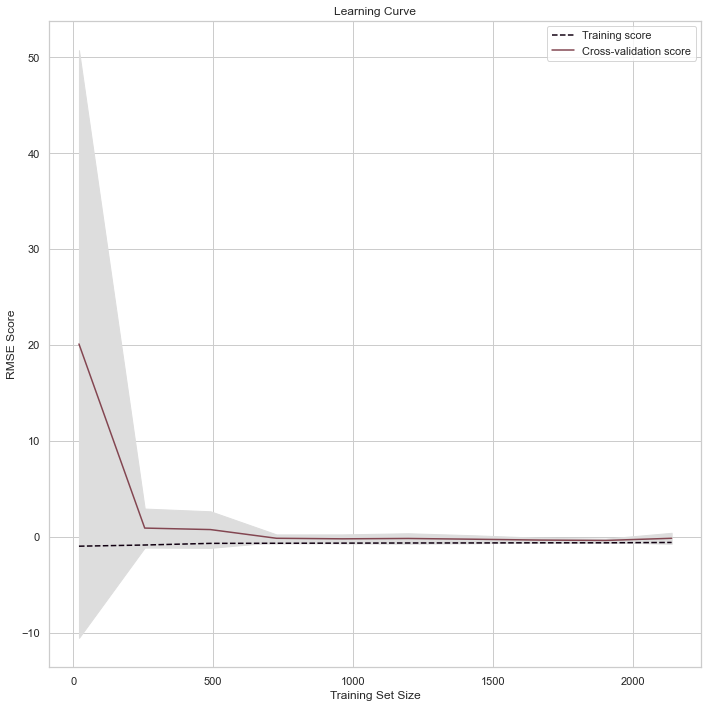

In [72]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.42531331322003363


(16808.90039, 873923712.0)

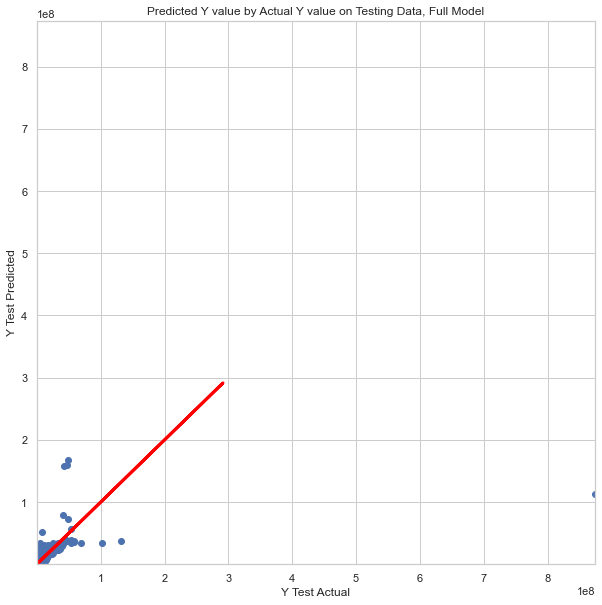

In [73]:
print('Coeff R2 =', las.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

In [74]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [75]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.115190,0.018633,0.004887,0.001133,0.001,{'alpha': 0.001},-0.001730,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,7,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
1,0.108709,0.012888,0.003889,0.000698,0.010,{'alpha': 0.01},-0.001730,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,6,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
2,0.087366,0.010862,0.003191,0.001074,0.100,{'alpha': 0.1},-0.001730,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,5,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
3,0.082778,0.011372,0.002993,0.000894,1.000,{'alpha': 1.0},-0.001729,0.651229,0.342554,0.373789,0.372269,0.588901,0.623859,0.433696,0.788644,0.719144,0.489236,0.221237,4,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024044
4,0.098037,0.026277,0.003491,0.001116,5.000,{'alpha': 5.0},-0.001725,0.651231,0.342554,0.373792,0.372273,0.588904,0.623864,0.433700,0.788643,0.719142,0.489238,0.221236,3,0.674604,0.648781,0.697049,0.661116,0.689892,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024044


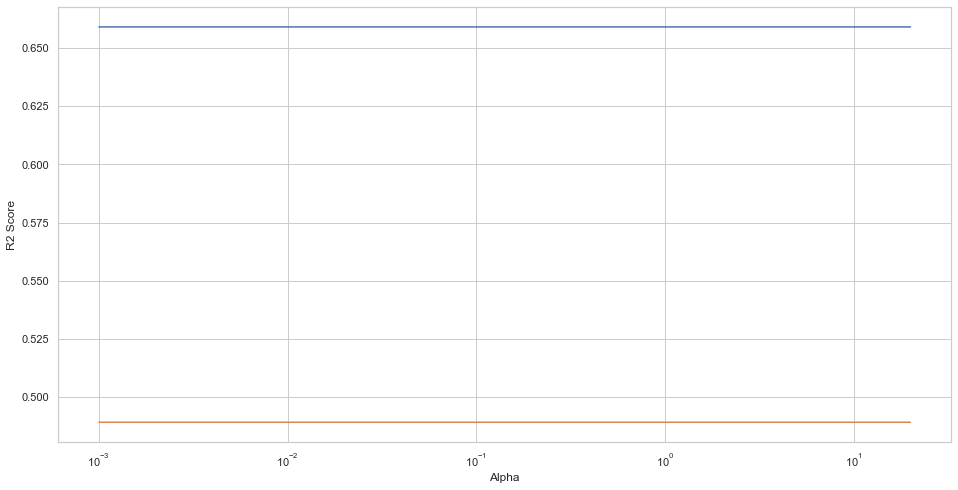

In [76]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [77]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 20.0}

In [78]:
las = Lasso(alpha=20)
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
y_test_pred = las.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560940944848652
0.20601276974496907


In [79]:
model_param = list(las.coef_)
model_param.insert(0,las.intercept_)
cols = df_pred_energy.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature','Coef']

In [80]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
40,Other - Education,3.224704e+07
47,Performing Arts,1.343040e+07
4,log_SiteEUI(kBtu/sf),1.031383e+07
3,log_PropertyGFABuilding(s),8.800086e+06
5,log_SourceEUI(kBtu/sf),6.685224e+06
2,log_PropertyGFATotal,4.501106e+06
36,Library,2.613075e+06
52,SiteEnergyUse(kBtu),2.097372e+06
1,log_NumberofFloors,2.046498e+06
35,Urgent Care/Clinic/Other Outpatient,1.741027e+06


Coeff R2 = 0.425318693289236


(16808.90039, 873923712.0)

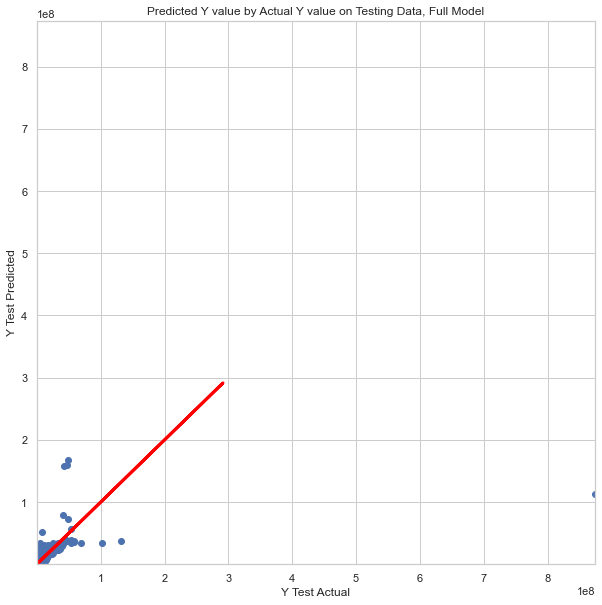

In [81]:
print('Coeff R2 =', las.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

## Ridge

In [82]:
lm = Ridge(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6561101168594237
0.19988997715584955


In [83]:
train_sizes, train_scores, test_scores = learning_curve(Ridge(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [84]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [85]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

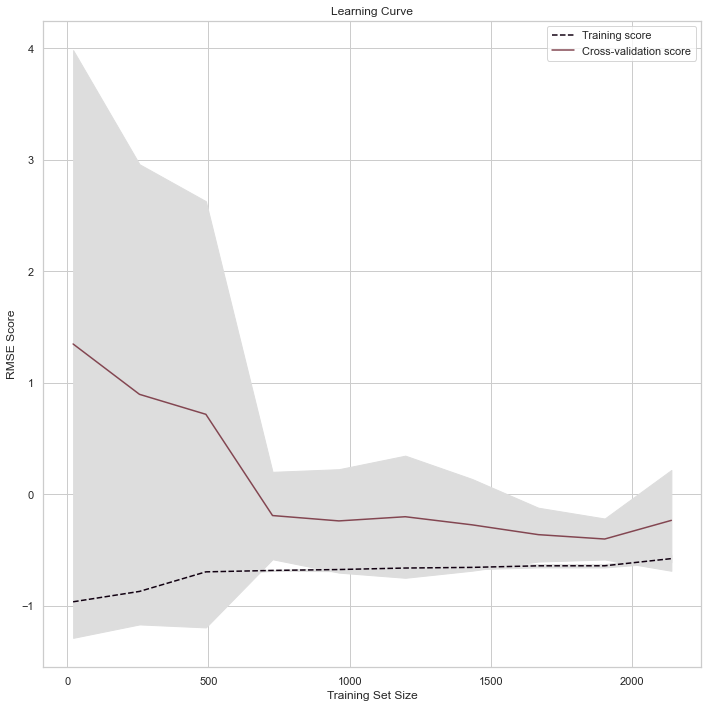

In [86]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [87]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.6561101168594237
0.19988997715584955


Coeff R2 = 0.422186563879026


(16808.90039, 873923712.0)

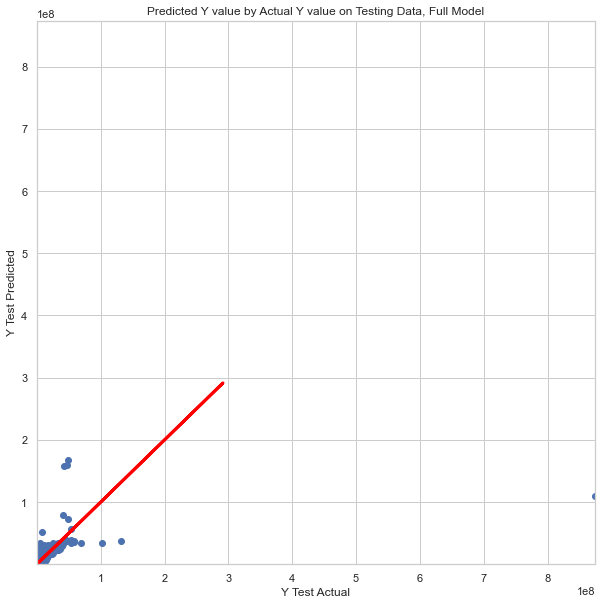

In [88]:
print('Coeff R2 =', ridge.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, ridge.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

In [89]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [90]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.006483,0.001624,0.004489,0.001202,0.001,{'alpha': 0.001},-0.005338,0.650588,0.342244,0.368961,0.360226,0.581893,0.621403,0.429514,0.780968,0.716491,0.484695,0.221251,10,0.674627,0.648863,0.697101,0.661176,0.690450,0.658193,0.656919,0.662073,0.631257,0.612070,0.659273,0.024038
1,0.006982,0.001479,0.003490,0.001117,0.010,{'alpha': 0.01},-0.005035,0.650651,0.342294,0.369403,0.361952,0.582592,0.621665,0.429966,0.781529,0.716622,0.485164,0.221190,9,0.674627,0.648862,0.697100,0.661175,0.690441,0.658191,0.656918,0.662072,0.631255,0.612069,0.659271,0.024037
2,0.005187,0.001163,0.003390,0.001017,0.100,{'alpha': 0.1},-0.002844,0.650994,0.342636,0.372021,0.369519,0.586453,0.623201,0.432560,0.784593,0.717244,0.487638,0.220835,8,0.674625,0.648833,0.697077,0.661148,0.690180,0.658122,0.656877,0.662035,0.631169,0.612033,0.659210,0.024018
3,0.004588,0.001494,0.002392,0.000662,0.200,{'alpha': 0.2},-0.001076,0.651172,0.342888,0.373398,0.372210,0.588217,0.624018,0.433875,0.785922,0.717355,0.488798,0.220510,7,0.674622,0.648805,0.697053,0.661122,0.689983,0.658056,0.656836,0.661999,0.631086,0.611997,0.659156,0.024007
4,0.006184,0.001773,0.003490,0.001117,0.500,{'alpha': 0.5},0.003343,0.651478,0.343478,0.375369,0.375091,0.590172,0.625248,0.435721,0.787125,0.716897,0.490392,0.219490,6,0.674614,0.648763,0.697015,0.661078,0.689736,0.657956,0.656771,0.661942,0.630963,0.611942,0.659078,0.023996


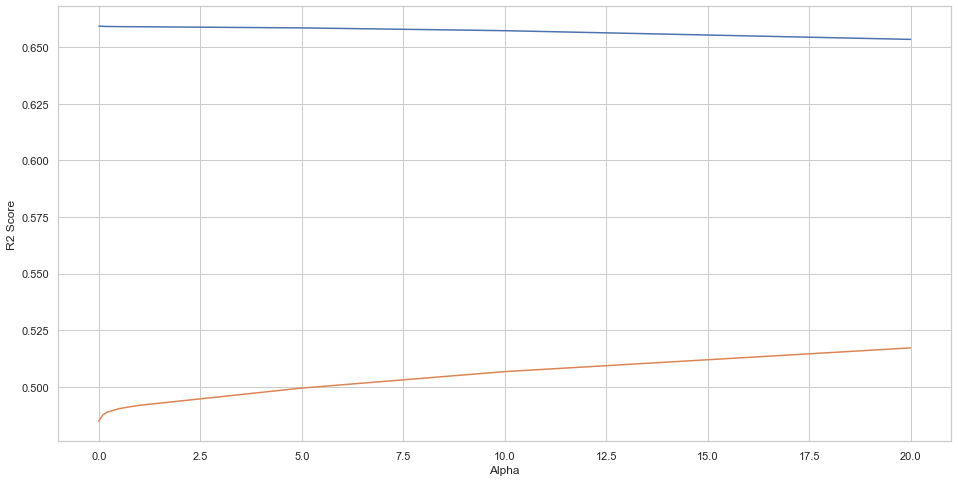

In [91]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [92]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 20.0}

In [93]:
ridge = Ridge(alpha = 20)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.6514500476818789
0.21322543739960642


In [94]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_pred_energy.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

In [95]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
40,Other - Education,2.777019e+07
47,Performing Arts,1.174283e+07
4,log_SiteEUI(kBtu/sf),8.843068e+06
1,log_NumberofFloors,7.246773e+06
5,log_SourceEUI(kBtu/sf),5.407442e+06
3,log_PropertyGFABuilding(s),4.762986e+06
2,log_PropertyGFATotal,4.224907e+06
36,Library,1.979817e+06
52,SiteEnergyUse(kBtu),1.339270e+06
35,Urgent Care/Clinic/Other Outpatient,1.041579e+06


Coeff R2 = 0.4267556088735984


(16808.90039, 873923712.0)

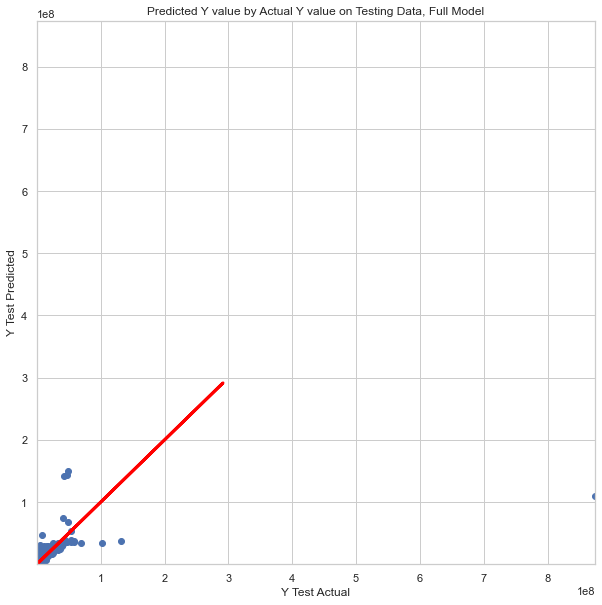

In [96]:
print('Coeff R2 =', ridge.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, ridge.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test), max(y_test))

Après avoir créé un modèle à la fois dans Ridge et Lasso, nous pouvons voir que les r2_scores sont presque les mêmes pour les deux

## ElasticNet

In [97]:
lm = ElasticNet(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560474477426229
0.21047862478024149


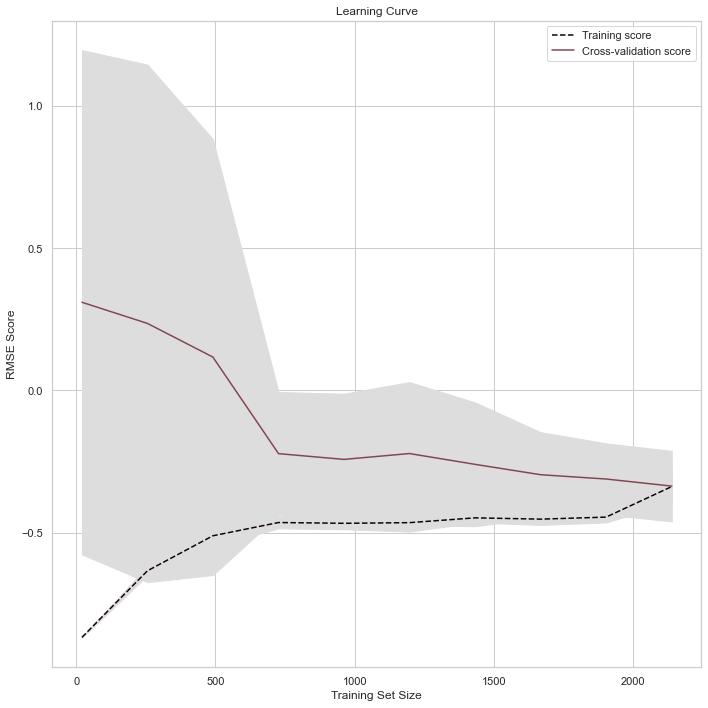

In [98]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(ElasticNet(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [99]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = ElasticNet()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [100]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.087665,0.015537,0.002992,0.000631,0.001,{'alpha': 0.001},0.009753,0.651824,0.344280,0.376921,0.377019,0.591195,0.626378,0.437204,0.787590,0.715893,0.491806,0.217897,5,0.674595,0.648726,0.696982,0.661046,0.689605,0.657890,0.656724,0.661904,0.630858,0.611881,0.659021,0.023998
1,0.076992,0.005639,0.003691,0.001002,0.010,{'alpha': 0.01},0.106454,0.655129,0.356499,0.394286,0.395014,0.595236,0.637673,0.454241,0.777130,0.690807,0.506247,0.190963,3,0.672880,0.647032,0.695220,0.659651,0.687666,0.656455,0.655175,0.660462,0.629166,0.610325,0.657403,0.023931
2,0.024136,0.002953,0.003789,0.000979,0.100,{'alpha': 0.1},0.473787,0.621261,0.389366,0.443686,0.435805,0.600044,0.662132,0.516665,0.670390,0.536134,0.534927,0.094677,1,0.620967,0.597526,0.641383,0.615622,0.632601,0.611564,0.609046,0.615600,0.582735,0.572228,0.609927,0.020020
3,0.015159,0.001245,0.003192,0.001163,0.200,{'alpha': 0.2},0.565476,0.577314,0.383617,0.455431,0.423290,0.594035,0.666991,0.537378,0.598415,0.460568,0.526251,0.086113,2,0.572593,0.552652,0.591253,0.572172,0.582720,0.567231,0.563717,0.571301,0.541746,0.540501,0.565589,0.015648
4,0.008975,0.001995,0.003092,0.000828,0.500,{'alpha': 0.5},0.617165,0.503344,0.357521,0.482878,0.382779,0.583770,0.670436,0.562020,0.500777,0.373065,0.503375,0.101973,4,0.498188,0.484936,0.514815,0.502196,0.508316,0.496014,0.490603,0.499947,0.480149,0.492057,0.496722,0.009887


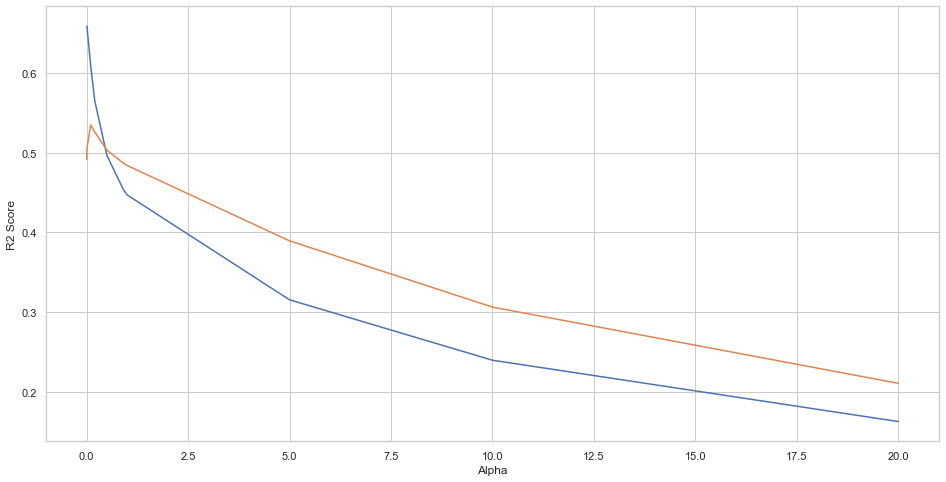

In [101]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [102]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0.1}

In [103]:
ridge = ElasticNet(alpha = 0.1)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.6070745207752528
0.20300293449874263


In [104]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_pred_energy.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

In [105]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
40,Other - Education,1.755359e+07
47,Performing Arts,8.018707e+06
4,log_SiteEUI(kBtu/sf),6.600347e+06
1,log_NumberofFloors,4.877383e+06
3,log_PropertyGFABuilding(s),4.442670e+06
5,log_SourceEUI(kBtu/sf),4.001787e+06
2,log_PropertyGFATotal,3.479196e+06
6,log_Build_Age,1.345538e+06
36,Library,1.108438e+06
7,log_surface_nb_building,7.471815e+05


NameError: name 'rfr' is not defined

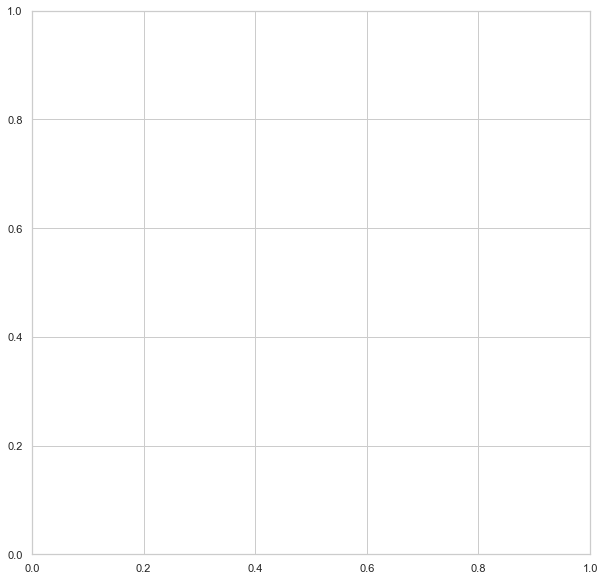

In [106]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(y_test, rfr.predict(X_test), alpha = .5)
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## GradientBoostingRegressor

In [ ]:
GB = GradientBoostingRegressor()
GB.fit(X_train,y_train)

y_train_pred = GB.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = GB.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(GradientBoostingRegressor(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [ ]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'n_estimators':range(80), 
                  'max_depth':[14],
                  'min_samples_split':[100],
                  'max_features':[10],
                  'subsample':[1]}


model = GradientBoostingRegressor()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

In [ ]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r

In [ ]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

In [ ]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'n_estimators':[80], 
                  'max_depth':[14],
                  'min_samples_split':[100],
                  'max_features':[10],
                  'subsample':[1]}


model = GradientBoostingRegressor()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

In [ ]:
y_train_pred = model_cv.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = model_cv.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

## RandomForestRegressor
Les hyperparamètres courants pour un RandomForestRegressor sont les suivants:

* n_estimators: nombre d'arbres de décision dans la forêt.
* criterion: fonction de coût utilisée pour mesurer la qualité de chaque séparation.
* max_depth: profondeur maximale de chaque arbre.
* min_samples_split: nombre minimum d'échantillons nécessaires pour diviser un noeud.
* min_samples_leaf: nombre minimum d'échantillons requis pour être un noeud feuille.
* min_weight_fraction_leaf: fraction minimale du poids total d'échantillons requis pour être un noeud feuille.
* max_features: nombre maximum de caractéristiques considérées lors de la recherche d'une meilleure séparation.
* max_leaf_nodes: nombre maximal de noeuds feuilles dans chaque arbre.
* min_impurity_decrease: réduit minimale de l'impureté pour diviser un noeud.



In [ ]:
# With no clear pattern detected, let's fit a random forest and check for feature importances.
rfr = RandomForestRegressor(n_estimators = 80, criterion = 'mse', random_state= 8, oob_score  = True)
rfr.fit(X_train, y_train)

In [ ]:
print(rfr.oob_score_)
# This is the R_squared on out-of-bag training data.

In [ ]:
np.mean((rfr.predict(X_test) - y_test)**2)
# This is the RSE on testing data.
# Given the magnitude of the response variable y, this is actually pretty impressive!

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(y_test, rfr.predict(X_test), alpha = .5)
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

# Model vs ENERGYSTARScore 